In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import allensdk
import pandas  # 1.1.1 by early 2021
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Data generator

#### Poisson

In [645]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1 = 20, 20
trial_length, num_trials = 2, 500
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)

#### Hawkes process

In [659]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'triangle', 'mu': [20., 20.], 'alpha': [[0., 0], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda stable: [20. 20.]
Gamma
[[0. 0.]
 [0. 0.]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.76it/s]


#### Amarasingham data (fixed number of cluster centers)

100%|█████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 71.88it/s]


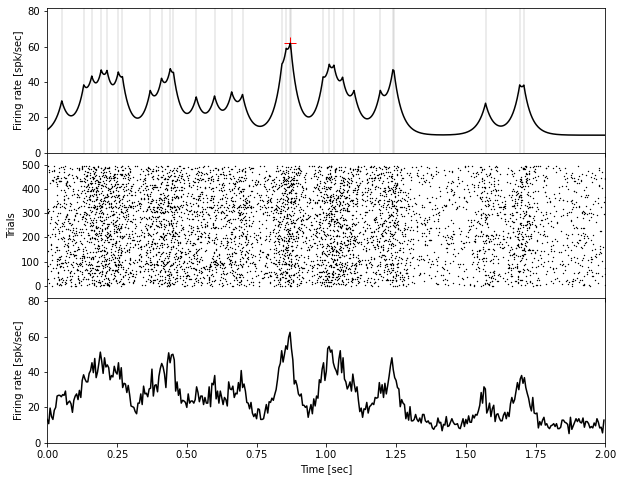

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)
trial_length = 2
num_peaks = 30
baseline = 10
num_trials = 250
sigma = 0.04

file_path = project_dir + 'Output/fig/eg_amarasingham_data.pdf'
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks, sigma, trial_length, num_trials*2, 
        baseline, sample_type='density', verbose=2, file_path=None)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

# synchrony_rate = 0
# spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
#     spike_times_x, spike_times_y, synchrony_rate, trial_length)
# synchrony_prob= 0.01
# spike_times_sync_x, spike_times_sync_y = generator.inject_prob_synchrony_to_spike_times(
#     spike_times_x, spike_times_y, synchrony_prob, trial_length)

#### Amarasingham + coupling filter.

In [160]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 250, 'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 50, 'baseline': 10, 'sigma': 0.04, 'random_seed': 2,
    'type': 'square', 'alpha': [[0., 4], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda_max (proposal): 394.61
lambda stable: [105.96  91.34]
100%|█████████████████████████████████████████████████████████████| 250/250 [00:26<00:00,  9.27it/s]


In [206]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 10, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.04, 'random_seed': 3,
    'type': 'square', 'alpha': [[0., 4], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda_max (proposal): 337.37
lambda stable: [90.59 78.09]
100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


#### Amarasingham non-repeated trials + coupling filter

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 50, 'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6,
    'type': 'square', 'alpha': [[0., 3], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.80it/s]


#### Basic: Linear Cox process (cluster centers from Poisson process)
For the coupling matrix, alpha, beta has format [[Target->Target, Source->Target], [Target->Source, Source->Source]]

In [5]:
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.08, 'random_seed': 222,
    'type': 'square', 'alpha': [[0., -4], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.20it/s]


#### Exp kernel + Linear Cox process

In [3]:
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 10
trial_window = [0, trial_length]
generator_par = {'num_trials': 50, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 222,
    'type': 'exp', 'alpha': [[0., 4], [0.0, 0.0]], 'beta': [[1.0, 50], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=0)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Self-coupling

In [ ]:
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 1, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 4, 'mu': 4, 'baseline': 3, 'window': 'gaussian', 'sigma': 0.08, 'random_seed': 222,
    'type': 'square', 'alpha': [[0., 3], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=3)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Double-coupling.
For the coupling matrix, alpha, beta has format [[Target->Target, Source->Target], [Target->Source, Source->Source]]

In [26]:
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 50, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.08, 'random_seed': 110,
    'type': 'square', 'alpha': [[0., 2.0], [2.0, 0.0]], 'beta': [[1.0, 0.03], [0.03, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=0)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Lagged Linear Cox process.

[2.04957354e-04 2.40670508e-02 6.33220473e-02 7.00734558e-02 1.19016236e-01 1.52217989e-01 1.63009490e-01
 2.40620812e-01 2.44997459e-01 2.71505692e-01 2.80159883e-01 3.41332409e-01 4.10971195e-01 4.91056110e-01
 5.16666643e-01 5.49271617e-01 5.51978048e-01 5.72886703e-01 5.91960104e-01 5.94803148e-01 6.03700835e-01
 6.61983906e-01 6.70926637e-01 7.61787436e-01 8.17657200e-01 8.73675659e-01 8.78142779e-01 9.51311241e-01
 9.90299792e-01 1.02658152e+00 1.11682571e+00 1.12296024e+00 1.14905982e+00 1.24773534e+00 1.25051181e+00
 1.30959035e+00 1.34196299e+00 1.35814497e+00 1.38268586e+00 1.50482364e+00 1.53700714e+00 1.58082989e+00
 1.61717201e+00 1.73003632e+00 1.79836211e+00 1.80816036e+00 1.81556061e+00 1.99406236e+00 2.05392669e+00
 2.08926400e+00 2.09768752e+00 2.18234483e+00 2.20394137e+00 2.28600325e+00 2.34503176e+00 2.42876692e+00
 2.44851506e+00 2.47885188e+00 2.52747542e+00 2.53824456e+00 2.56720259e+00 2.57034345e+00 2.61196713e+00
 2.66977710e+00 2.67505287e+00 2.71038355e+00 

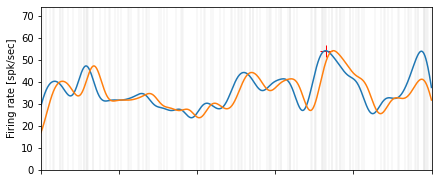

In [35]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
generator_par = {'num_trials': 1, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'delays': [0, 0.1], 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_delayed_nonrepeated(generator_par, verbose=3)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Sinusoid linear cox

lambda_max (proposal): 123.6
lambda stable: [31.8 30. ]


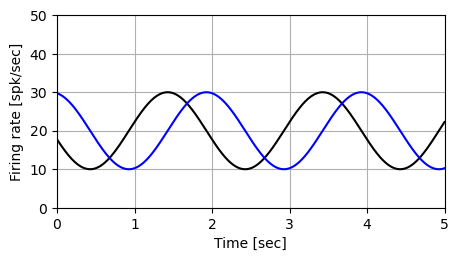

In [10]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
amplitude = 10

generator_par = {'num_trials': 1, 'trial_length': trial_length, 'trial_window': trial_window,
    'baseline': 20, 'amplitude': amplitude, 'frequency': 0.5, 'window': 'sinusoid', 'delays': [0, 32/64], 'random_seed': 3,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, beta/1000], [1.0, 1.0]], 'num_nodes': 2}

init_lag = np.random.rand()
generator_par['delays'][0] = generator_par['delays'][0] + init_lag
generator_par['delays'][1] = generator_par['delays'][1] + init_lag

spike_times = generator.generate_linear_cox_coupling_filter_spike_times_delayed_sinusoid(generator_par, verbose=3)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

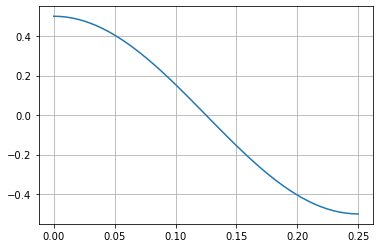

In [133]:
dt = 0.001
T = 5
freq = 2
t = np.arange(0,T+dt,dt)
phase = np.linspace(0,1/2/freq,50)

corr = np.zeros_like(phase)
for i, shift in enumerate(phase):
    y1 = np.sin(2*np.pi*freq*t)
    y2 = np.sin(2*np.pi*freq*(t-shift))
    corr[i] = np.dot(y1, y2) * dt / T
    # plt.plot(t, y1)
    # plt.plot(t, y2)

plt.plot(phase, corr)
plt.grid()


#### Check data statistics.

layers 3, nodes 2, trials 50
meanFR [31.872 29.31 ]	meanISI [32.045 29.438]


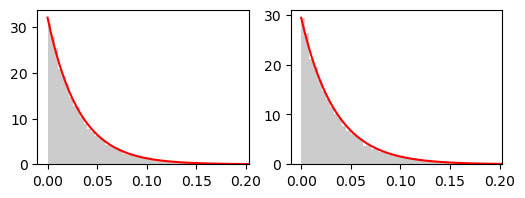

layers 3, nodes 2, trials 50


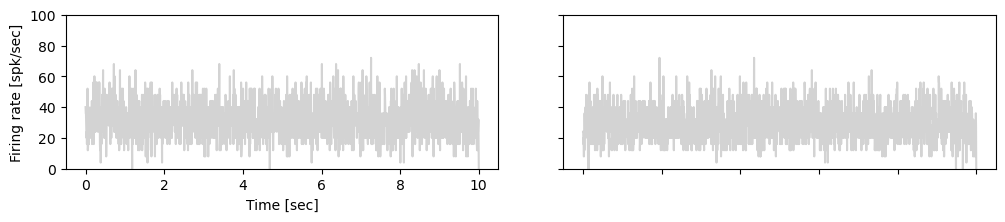

In [229]:
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

## Paper e.g.

In [147]:
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.05, 'random_seed': 0,
    'type': 'square', 'alpha': [[0., -3], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.28it/s]


100%|█████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.27it/s]
Save figure to: D:/Brain_Network/Output/fig/eg_amarasingham_square_filter_weak_ccg_spk2ms_jitterwindow120ms.pdf


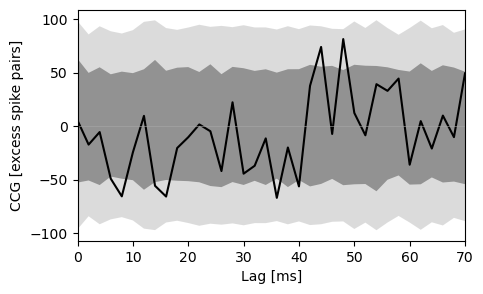

In [206]:
jittertool = jitter.JitterTool()
spk_bin_width = 0.002
lag_range = [-0.00, 0.07]
jitter_window_width = 0.12
distribution_type='mc_sim'
num_jitter = 300
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_ccg_spk2ms_jitterwindow120ms.pdf'
ret_vals = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, trial_length, lag_range, jitter_window_width,
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=True, file_path=file_path)

num_trials 100
X.shape (13044, 8), basis_integral.shape (8, 1),beta.shape(8, 1)
  7%|████▎                                                         | 7/100 [00:00<00:00, 467.84it/s]
gradient [-6.16909023e-06 -7.97800924e-05 -5.49320383e-07 -1.07126102e-06 -1.59154479e-06 -2.12669437e-06
 -2.17256652e-06 -2.91483420e-06]
num itr 7 [[-29664.22765818]] 2.3766790722690168e-06
beta [29.23991066  0.37687129 -4.14238441 -0.84163707 -4.55123657 -0.7796036  -4.08153365  0.67262165]
filter integral [-0.10561288]
save figure: D:/Brain_Network/Output/fig/bspline_our_method.pdf


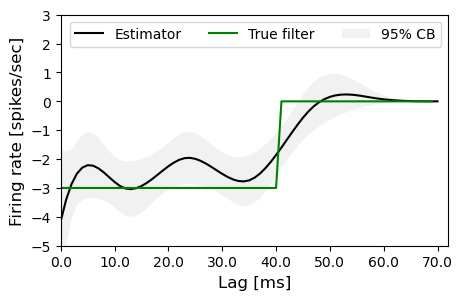

In [207]:
jittertool = jitter.JitterTool()
# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par = {'filter_type': 'bspline', 'num_knots': 7, 'knot_space_par': 20, 'filter_length': 0.07, 'num_tail_drop': 3,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
file_path = project_dir + 'Output/fig/bspline_our_method.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.072], ylim=[-5,3], file_path=file_path)

num_trials 100
X.shape (13044, 7), basis_integral.shape (7, 1),beta.shape(7, 1)
 23%|██████████████                                               | 23/100 [00:00<00:00, 623.28it/s]
gradient [ 3.28330259e-07 -9.14444627e-08 -1.98615425e-07 -5.27634143e-07 -1.21381726e-06 -1.02526135e-06
 -3.55675255e-07]
num itr 23 [[-29519.54457781]] 5.218627033981571e-07
beta [24.40370236 -0.09490987  1.28882346 -1.13398871  2.51538837  1.18972454  0.65627363]
filter integral [0.05643673]
save figure: D:/Brain_Network/Output/fig/bspline_hawkes.pdf


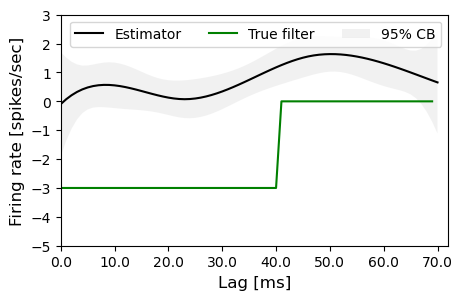

In [208]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 1.2, 'filter_length': 0.07, 'num_tail_drop': 0,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
file_path = project_dir + 'Output/fig/bspline_hawkes.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.072], ylim=[-5,3], file_path=file_path)

## Hawkes process model fitting.

In [28]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par)

filter integral [0.16201869]


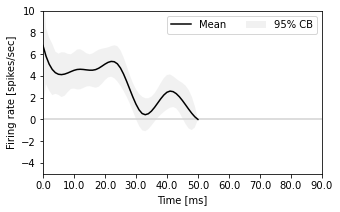

In [29]:
file_path = project_dir + 'Output/fig/poisson_flat.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-5, 10], file_path=None)

# Jitter correction for coupling filters

In [165]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1, 
             'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12, 
             'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12,
#              'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_raw, model_par_jitter = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


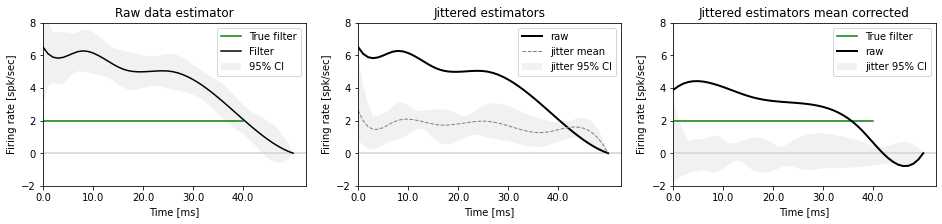

In [166]:
file_path = project_dir + 'Output/fig/eg_amarasingham_negsquare_filter_jitter_regression_jitterwindow120ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter,
    generator_par, ylim=[-2, 8], file_path=None)

### Jitter $\beta$ offset regression.
We use the jitter mean as the filter parameter offset, the regression captures the extra term.

In [2916]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.2, 'num_tail_drop': 2, 'filter_length': 0.04,
             'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 20, 'jitter_window_width': 0.08,
             'learning_rate': 0.9, 'max_num_itrs': 300, 'epsilon': 1e-8}
model_par_raw, model_par_jitter = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_length, model_par, verbose=True)

100%|███████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.79it/s]


In [ ]:
file_path = project_dir + 'Output/fig/triangle_jitter_filter.pdf'
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, file_path=None)

# Nuisance variable correction.

### Kernel width selection.

In [ ]:
model_par = {'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_regression(spike_times_x[:20], spike_times_y[:20], model_par)

In [ ]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width(spike_times_x[:20], spike_times_y[:20], model_par)

In [ ]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_simple(spike_times_x[:20], spike_times_y[:20], model_par)

#### No filter.

In [30]:
model_par = {'filter_type': 'none',
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_window, model_par)

##### Gaussian kernel nuisance.

gaussian window integral 0.9999994266968563
np.sum(basis): 1062087.7524891503


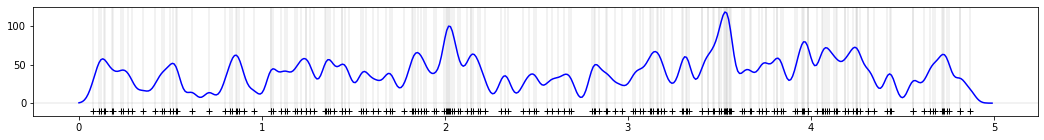

In [31]:
sample_y = np.ones([len(spike_times_x),1]) @ np.arange(0, trial_length, 0.01).reshape(1,-1)
_=jittertool.construct_regressors_gaussian_kernel(spike_times_x, sample_y, 0.03, [0,trial_length], verbose=True)

num_trials 50
X.shape (15936, 7), basis_integral.shape (7, 1),beta.shape(7, 1)
  7%|████▎                                                         | 7/100 [00:00<00:00, 412.12it/s]
gradient [-8.67850139e-06 -8.03454803e-05 -3.52439275e-06 -5.79362805e-06 -7.37575959e-06 -6.18346161e-06
 -3.54909466e-06]
num itr 7 [[-39462.95562362]] 2.030052927405601e-06
beta [30.4116826   0.40782597  3.30941663  1.31819334  1.41508675  0.06182081 -0.86588377]
filter integral [0.04982318]


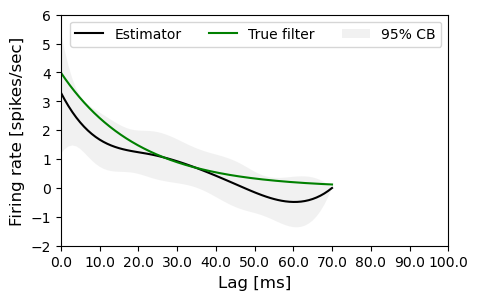

In [230]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 1.2, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

##### Exp filter basis.

In [233]:
# Temporal code for generating spikes.
file_path = project_dir + 'Output/fig/linear_cox_intensity_demo.pdf'
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 10
trial_window = [0, trial_length]
generator_par = {'num_trials': 200, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 10, 'mu': 10, 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 5,
    'type': 'exp', 'alpha': [[0., 4], [0.0, 0.0]], 'beta': [[1.0, 30], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=file_path, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.00it/s]


Only fit amplitude using old code.

In [112]:
# Hawkes.
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'exp', 'filter_beta': 30,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 200, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

num_trials 100
X.shape (10666, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
 10%|██████▍                                                      | 21/200 [00:00<00:00, 779.82it/s]
gradient [-1.05307913e-06 -1.65464585e-05]
num itr 21 [[-14613.95811275]] 7.5799582566205e-07
beta [9.97379173 2.10274344]


In [108]:
# Exp + fixed beta + smooth baseline.
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'exp', 'filter_beta': 30,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=2)
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

num_trials 100
X.shape (31833, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  2%|█▎                                                          | 21/1000 [00:00<00:02, 389.92it/s]
gradient [-5.99617306e-06 -6.89438896e-04 -4.52725067e-05]
num itr 21 [[-78818.25849263]] 8.303655158470313e-07
beta [30.01542855  0.45068917  1.82943955]


Fit kernel timescale + Hawkes. Gamma gradient decent works very well.

In [234]:
jittertool = jitter.JitterTool()
# Warmup
model_par = {'filter_type': 'exp', 'filter_beta': 30,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-4}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=2)
# Fit timescale.
model_par = {'filter_type': 'exp', 'filter_beta': 50,
             'append_nuisance': ['const'], 'beta_init':model_par_hat['beta'],
             'const_offset': 0, 'learning_rate': 0.1, 'max_num_itrs': 20, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_exp_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, update_gamma_only=True, verbose=True)
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

num_trials 200
X.shape (67850, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
  2%|▉                                                           | 16/1000 [00:00<00:07, 132.58it/s]
gradient [-0.00036141 -0.00336655]
num itr 16 [[-171787.22742756]] 9.89909258919397e-05
beta [28.07616196  5.89252663]
num_trials 200
X.shape (67850, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
gamma 28.606: 100%|█████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]
gradient [16.22479792 19.10600795]
num itr 19 [[-171789.96892169]] 0.0
beta [28.07616196  5.89252663]


D:/Brain_Network/Code\jitter.py:4522: UserWarning: Reach max itrs 20. Last err:0.000e+00
  # Check convergence.


Fit timescale + Baseline.

100%|███████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]
optimal kernel width  130.0


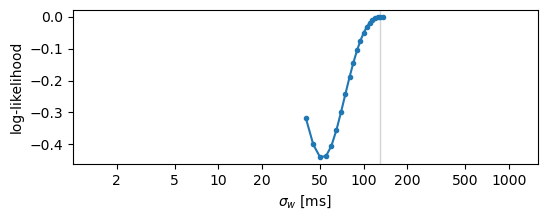

In [188]:
kernel_widths = np.arange(40, 140, 5) / 1000
model_par = {'trial_window': [0, trial_length], 'filter_type': 'exp', 'filter_beta': 30, 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_regression(spike_times_x[:50], spike_times_y[:50], model_par, kernel_width_grid=kernel_widths)

In [237]:
jittertool = jitter.JitterTool()

# model_par = {'filter_type': 'exp', 'filter_beta': 28.6,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.125,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 50, 'epsilon': 1e-6}
# model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
#     spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=2)

model_par = {'filter_type': 'exp', 'filter_beta': 28.6, 'beta_init': np.array([[29.5],[0.0],[5.23]]), # model_par_hat['beta']
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.125,
             'const_offset': 0, 'learning_rate': 0.1, 'max_num_itrs': 10, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_exp_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, update_gamma_only=True, verbose=True)
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

num_trials 200
X.shape (67850, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
gamma 31.422: 100%|█████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]
gradient [34.42528301 39.16701967  9.22640689]
num itr 9 [[-171763.33661103]] 0.0
beta [29.5   0.    5.23]


D:/Brain_Network/Code\jitter.py:4522: UserWarning: Reach max itrs 10. Last err:0.000e+00
  # Check convergence.


grid-search for beta: a clue for local convex optimization. gradient decent should work.

num_trials 200
X.shape (49455, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  8%|████▉                                                        | 16/200 [00:00<00:01, 152.79it/s]
gradient [ 0.00012724 -0.00830175 -0.00213387]
num itr 16 [[-109433.26946982]] 5.453479949725634e-05
beta [1.97221250e+01 1.33758545e-03 2.30583564e+00]
num_trials 200
X.shape (49455, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  8%|████▉                                                        | 16/200 [00:00<00:01, 174.46it/s]
gradient [-1.55793737e-06 -8.65617537e-03 -2.24389358e-03]
num itr 16 [[-109466.55473194]] 5.836908803456936e-05
beta [ 2.02906151e+01 -2.02798067e-04  3.05590499e+00]
num_trials 200
X.shape (49455, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  8%|████▉                                                        | 16/200 [00:00<00:01, 168.82it/s]
gradient [-6.35238778e-05 -8.84572418e-03 -2.14138296e-03]
num itr 16 [[-109479.82619454]] 5.920678203429411e-05
beta [2.08840900e+01 1.

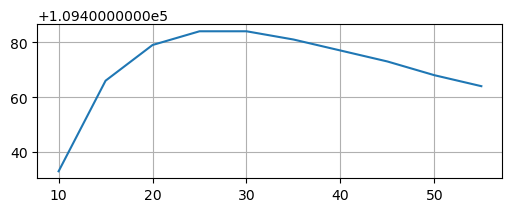

In [214]:
beta_list = np.arange(10, 60, 5)
nll_list = np.zeros_like(beta_list)

for i, gamma in enumerate(beta_list):
    model_par = {'filter_type': 'exp', 'filter_beta': gamma,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.12,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 200, 'epsilon': 1e-4}
    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=1)
    nll_list[i] = model_par_hat['nll']

plt.figure(figsize=[6,2])
plt.plot(beta_list, -nll_list)
plt.grid()

#### Const + triangle

In [ ]:
sample_y = np.arange(0, trial_length, 0.01).reshape(1,-1)
_=jittertool.construct_regressors_triangle_kernel(spike_times_x[0], sample_y, 0.03, verbose=True)

In [40]:
jittertool = jitter.JitterTool()
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.05,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x, spike_times_y, trial_window, model_par, verbose=True)

num_trials 50
X.shape (10389, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  7%|████▎                                                         | 7/100 [00:00<00:00, 877.39it/s]
gradient [-1.33113286e-06 -6.92560008e-05 -3.36396717e-06]
num itr 7 [[-28458.09339431]] 6.257578030466338e-07
beta [41.55599997  0.12690338  2.40766011]


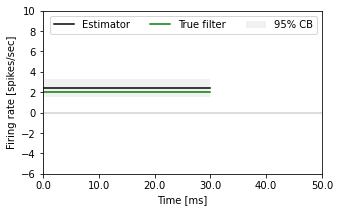

In [41]:
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_nuisance_regression_jitterwindow120ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-6, 10], file_path=None)

##### Interval mean.

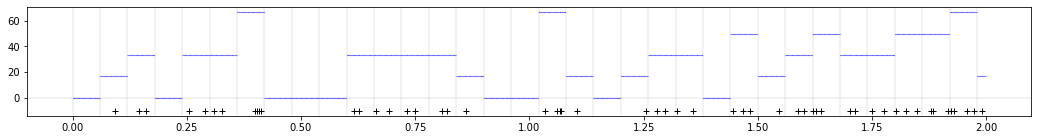

In [80]:
sample_y = np.ones([len(spike_times_x),1]) @ np.arange(0, trial_length, 0.001).reshape(1,-1)
_=jittertool.construct_regressors_jitter_mean(spike_times_x, sample_y, trial_length, 0.06, verbose=True)

In [373]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['jitter_mean'], 'jitter_window_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 50, 'epsilon': 1e-8}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par)

filter integral [0.16936276]


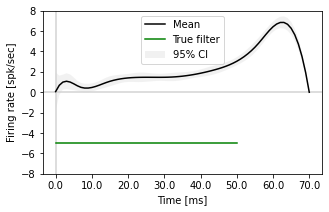

In [374]:
output_figure_path = project_dir + 'Output/fig/triangle_filter.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-8, 8], output_figure_path=None)

##### Const + interval mean

In [375]:
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'jitter_mean'], 'jitter_window_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par)

filter integral [-0.18365452]


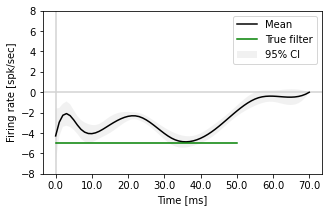

[[18.55487109  0.21203477 -4.27981739 -0.45697218 -5.05666135 -3.26622809 -1.41483502 -5.62043604
  -4.19761289  0.88789924 -1.02533565]]


In [376]:
output_figure_path = project_dir + 'Output/fig/triangle_filter.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-8,8], output_figure_path=None)
print(model_par_hat['beta'].T)

##### Square kernel nuisance.

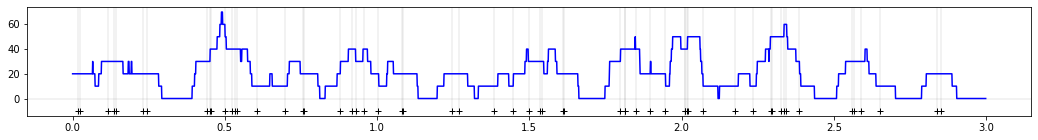

In [2549]:
sample_y = np.ones([len(spike_times_x),1]) @ np.arange(0, trial_length, 0.001).reshape(1,-1)
_=jittertool.construct_regressors_square_kernel(spike_times_x, sample_y, trial_length, 0.1, verbose=True)

In [383]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'square_kernel'], 'kernel_width': 0.07,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par)

filter integral [-0.21640421]


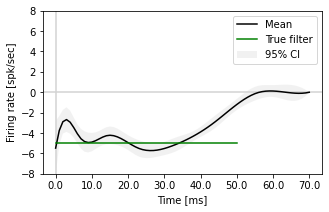

In [384]:
output_figure_path = project_dir + 'Output/fig/nuisance_correction_square_kernel.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-8, 8], output_figure_path=None)

##### Laplacian kernel nuisance.

laplacian window integral 0.9856304039095609


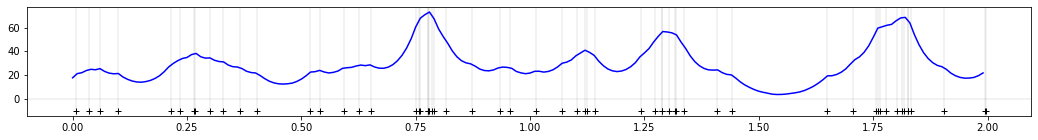

In [342]:
sample_y = np.ones([len(spike_times_x),1]) @ np.arange(0, trial_length, 0.01).reshape(1,-1)
_=jittertool.construct_regressors_laplacian_kernel(spike_times_x, sample_y, 0.07, verbose=True)

In [410]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.08, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'laplacian_kernel'], 'kernel_width': 0.04,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0, trial_length], model_par)

filter integral [-0.23163459]


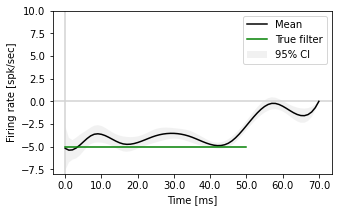

In [411]:

jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-8, 10], output_figure_path=None)

##### Discrete optimization verification Gaussian.

In [916]:
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:150], spike_times_y[:150], [0, trial_length], model_par, verbose=True)

X.shape (31664, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 14%|████████                                                   | 136/1000 [00:00<00:02, 361.71it/s]
num itr 136 [[-87228.28384014]] 9.642401914145005e-07
beta [24.44027467  0.3999592   1.90345317]
gradient [3.91689822e-05 8.90058545e-04 4.82357075e-06]


In [911]:
dt = 0.001
model_par_discrete = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
beta=jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:5], spike_times_y[:5], trial_window, dt, model_par_discrete)

num spikes x 1011 y 1112
continuous integral  [[ 25.         847.89263584  30.33      ]]
discrete integral    [[ 25.         847.89061927  30.294     ]]


##### Discrete optimization verification Triangle.

In [900]:
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 1,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:5], spike_times_y[:5], [0, trial_length], model_par, verbose=True)

X.shape (1112, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 14%|████████                                                  | 139/1000 [00:00<00:00, 3484.29it/s]
num itr 139 [[-3123.68926136]] 9.211852564083856e-07
beta [22.51097654  0.45550994  3.53144062]
gradient [ 8.96153484e-07  2.21255050e-05 -3.85990223e-07]


In [909]:
dt = 0.001
model_par_discrete = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 3,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
beta=jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:5], spike_times_y[:5], trial_window, dt, model_par_discrete)

num spikes x 1011 y 1112
continuous integral  [[ 25.         912.46923631  30.33      ]]
discrete integral    [[ 25.         907.51309137  30.294     ]]


##### Discrete optimization verification (L2 loss)

In [791]:
dt = 0.001
model_par_discrete = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.2,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 200, 'epsilon': 1e-6}
beta=jittertool.bivariate_discrete_time_coupling_filter_regression_L2_loss(
    spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_discrete, verbose=True)
model_par_discrete['beta'] = beta

X.shape (250000, 3) beta.shape (3, 1)
sum spikes, lambda  10526.0 10526.000000000004
itr0	loss: 10478.8	beta: [42.28345959  0.16133374  1.54314093]
itr20	loss: 10469.0	beta: [42.50279768  0.35851817  3.42918997]
itr40	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr60	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr80	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr100	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr120	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr140	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr160	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]
itr180	loss: 10469.0	beta: [42.50279908  0.35851943  3.42920207]


### Target self-coupling

In [110]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 200, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 9,
    'type': 'square', 'alpha': [[-6., 3], [0.0, 0.0]], 'beta': [[0.03, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, file_path=None, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.30it/s]


100%|███████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]
optimal kernel width  90.0


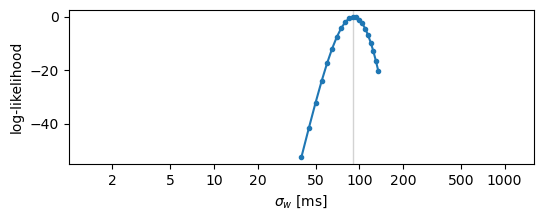

100%|███████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.03s/it]
optimal kernel width  95.0


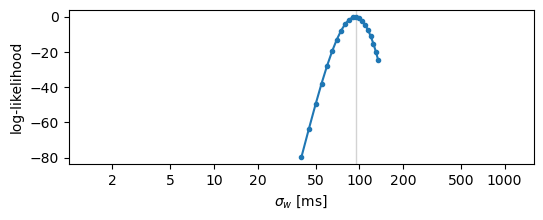

100%|███████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]
optimal kernel width  115.0


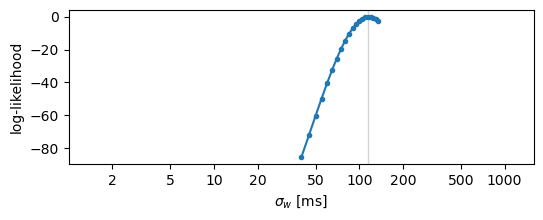

In [128]:
kernel_widths = np.arange(60, 140, 5) / 1000
model_par = {'trial_window': trial_window, 'filter_type': 'square', 'filter_length': 30, 
             'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_regression(spike_times_x, spike_times_y, model_par, kernel_width_grid=kernel_widths)

model_par = {'trial_window': trial_window, 'filter_type': 'square', 'filter_length': 30, 'self_filter_type': 'square', 'self_filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_full_regression(spike_times_x, spike_times_y, model_par, kernel_width_grid=kernel_widths)

model_par = {'dt': 0.001, 'trial_window': trial_window, 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par, kernel_width_grid=kernel_widths)

num_trials 200
X.shape (27666, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  2%|█▎                                                          | 22/1000 [00:00<00:02, 387.20it/s]
gradient [-4.14362125e-06 -3.94303754e-04 -3.15855534e-05]
num itr 22 [[-64716.02632539]] 5.433667458198954e-07
beta [27.66599984  0.33969345  2.33905909]


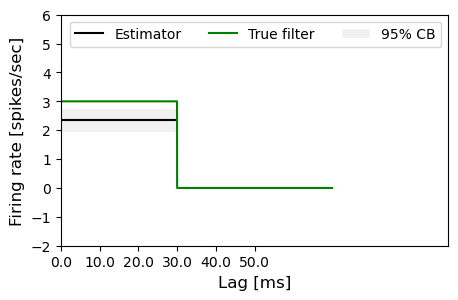

In [134]:
jittertool = jitter.JitterTool()
# model_par = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 1.2, 'filter_length': 0.07, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.095,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)


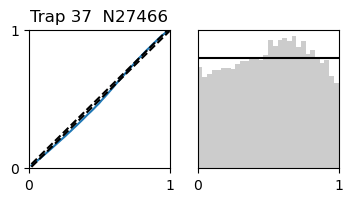

In [135]:
# Replicate possible lack-of-fit due to missing self-coupling.
u_list = jittertool.ks_test(spike_times_x, spike_times_y, trial_window, model_par_hat, dt=0.0002, test_size=0.01, verbose=True)

num_trials 200
X.shape (27666, 4), basis_integral.shape (4, 1),beta.shape(4, 1)
 23%|██████████████                                               | 23/100 [00:00<00:00, 366.22it/s]
gradient [-5.04073978e-06 -1.96503982e-04 -1.56638355e-05  9.40795181e-06]
num itr 23 [[-65021.05735087]] 5.447157542248782e-07
beta [27.66599985  0.3977443   2.48898127 -4.68125257]


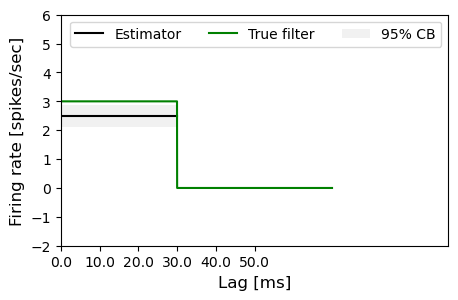

In [133]:
jittertool = jitter.JitterTool()
# model_par = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 1.2, 'filter_length': 0.07, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par = {'filter_type': 'square', 'filter_length': 0.03, 'self_filter_type': 'square', 'self_filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.095,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_full_regression(
    spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.1], ylim=[-2,6], file_path=None)

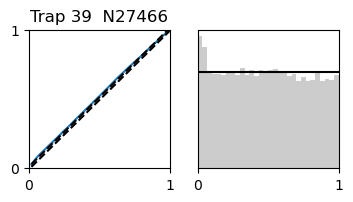

In [132]:
u_list = jittertool.ks_test_self_coupling(spike_times_x, spike_times_y, trial_window, model_par_hat, dt=0.002, test_size=0.01, verbose=True)

### Visualize the kernels.

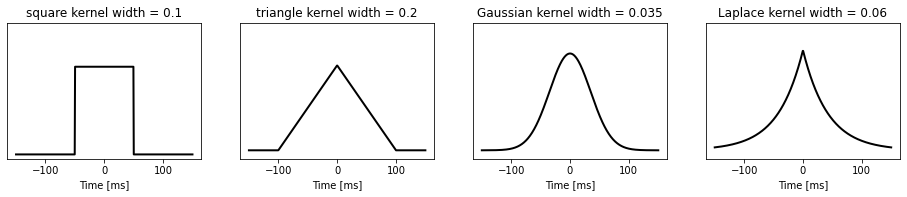

In [90]:
file_path = project_dir + 'Output/fig/nuisance_kernel_example.pdf'
jittertool.plot_kernels(file_path=None)

### Compare different nuisance.

In [ ]:
jittertool = jitter.JitterTool()
file_path = project_dir + 'Output/fig/nuisance_regressor_eg_square_kernel.pdf'
jittertool.compare_nuisance_regressor_baseline(spike_times_x, trial_length, 'square_kernel', generator_par, file_path=None)
jittertool.compare_nuisance_regressor_baseline(spike_times_x, trial_length, 'gaussian_kernel', generator_par, file_path=None)

## Batch training.

##### Batch training.

In [143]:
jittertool = jitter.JitterTool()
batch_size = 300
batch_ids = random.sample(range(num_trials), batch_size)
spike_times_x_batch = [spike_times_x[idx] for idx in batch_ids]
spike_times_y_batch = [spike_times_y[idx] for idx in batch_ids]
model_par = {'filter_type': 'bspline', 'num_knots': 7, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.04,
             'append_nuisance': ['const'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 30, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x_batch, spike_times_y_batch, trial_window, model_par, verbose=False)

100%|███████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


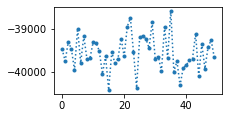

In [145]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 7, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.04,
             'append_nuisance': ['const'], 'kernel_width': 0.12, 'const_offset': 0,
             'batch_size':300, 'learning_rate': 0.9, 'max_num_itrs': 50, 'epsilon': 0.05, 'random_seed':0}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression_batch(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)

filter integral [0.05571951]


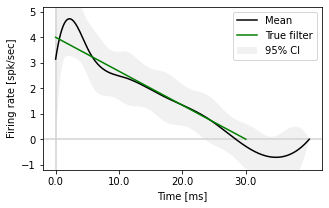

[[20.25038655  3.14511577  5.94453134  2.58766637  2.5647312   1.57318086  0.96507994 -0.88035269
  -0.80944665]]


In [144]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, filter_par, output_figure_path=None)
print(model_par_hat['beta'].T)

# Jitter CCG.

100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.58it/s]


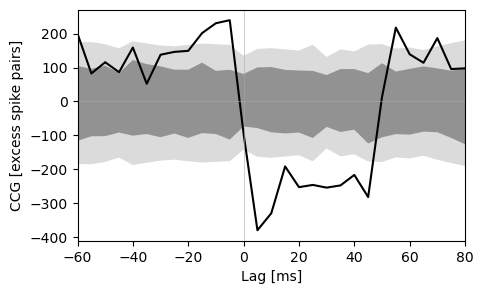

In [106]:
jittertool = jitter.JitterTool()
spk_bin_width = 0.005
lag_range = [-0.06, 0.08]
jitter_window_width = 0.12
distribution_type='mc_sim'
num_jitter = 100
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_ccg_spk5ms_jitterwindow120ms.pdf'
ret_vals = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, trial_length, lag_range, jitter_window_width,
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=True, file_path=None)

# ROC analysis.

### Data generator Hawkes process.

In [203]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 250, 'random_seed': None,
        'type': 'square', 'mu': [20., 20.], 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + f'Hawkes_square_alpha2_beta40ms_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(1), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=0)
#     generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=0)
    file_path = data_dir + f'Hawkes_square_alpha2_beta40ms_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


### Data generator Amarasingham + coupling filter.

In [345]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 2
trial_window = [0, trial_length]
alpha = 0.5
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 250, 'baseline': 10, 'sigma': 0.04, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
file_path = data_dir + f'amarasingham_square_alpha{alpha}_beta40ms_generator_par.pkl'
util.save_variable(file_path, generator_par)

for itr in tqdm(range(50, 200), ncols=100, file=sys.stdout):
    generator_par['random_seed'] = itr
    spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=0)
#     generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=0)
#     _=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
    file_path = data_dir + f'amarasingham_square_alpha{alpha}_beta40ms_itr{itr}.pkl'
    util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/amarasingham_square_alpha0.5_beta40ms_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 150/150 [37:38<00:00, 15.06s/it]


###  Fast regression model
Model fitting then save model list.

In [14]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/'
model_name = 'amarasingham_square_alpha0_beta40ms'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
model_par_list = []

model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.06, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

num_itrs = 5
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout) # range(num_itrs)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
            spike_times_x, spike_times_y, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)
#     jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-8, 8])

# file_path = model_dir + f'{model_name}_kernel120ms_model_par_list.pkl'
# util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.23it/s]


num_models:300
num_models:300
num_models:300
num_neg:300	um_pos:300	
num_neg:300	um_pos:300	
save figure: D:/Brain_Network/Output/fig/amarasingham_square_alpha_0.5_1_beta40ms_roc.pdf


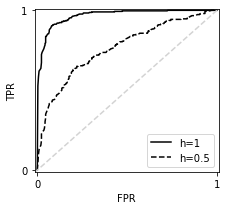

num_models:300
num_models:300
num_models:300
num_neg:300	um_pos:300	
num_neg:300	um_pos:300	
save figure: D:/Brain_Network/Output/fig/amarasingham_square_alpha_N0.5_N1_beta40ms_roc.pdf


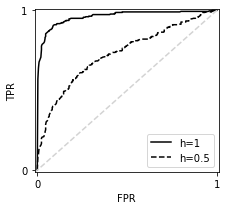

In [21]:
# Positive filters.
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha1_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals1 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0.5_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals2 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/fig/amarasingham_square_alpha_0.5_1_beta40ms_roc.pdf'
jittertool.roc(neg_pos_score_pairs=[(p_vals_null, p_vals1), (p_vals_null, p_vals2)], file_path=file_path)

# Negative filters.
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alphaN1_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals1 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alphaN0.5_beta40ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals2 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)
file_path = project_dir + 'Output/fig/amarasingham_square_alpha_N0.5_N1_beta40ms_roc.pdf'
jittertool.roc(neg_pos_score_pairs=[(p_vals_null, p_vals1), (p_vals_null, p_vals2)], file_path=file_path)

num_models:300
Save figure to: D:/Brain_Network/Output/fig/amarasingham_nuisance_regression_kernel120ms_null_pval_qq_pot.pdf


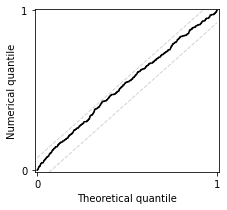

In [22]:
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0_beta40ms_kernel120ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

# file_path = project_dir + 'Output/fig/amarasingham_nuisance_regression_kernel120ms_null_pval_distribution.pdf'
# jittertool.plot_p_value_distribution([p_vals_null], bin_width=0.05, file_path=None)
file_path = project_dir + 'Output/fig/amarasingham_nuisance_regression_kernel120ms_null_pval_qq_pot.pdf'
jittertool.plot_p_value_qq_plot(p_vals_null, file_path=file_path)

#### Linear Cox dataset.

num_models:100
num_models:300
num_models:100
num_models:100
num_neg:100	um_pos:300	
num_neg:100	um_pos:100	
num_neg:100	um_pos:100	
save figure: D:/Brain_Network/Output/fig/linear_cox_beta30ms_kernel125ms_roc.pdf


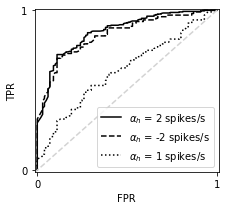

In [66]:
# Positive filters.
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

# file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated_kernel120ms_model_par_list.pkl'
file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_kernel125ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_trials10_nonrepeated_kernel125ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals1 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma_100ms_trials10_nonrepeated_kernel125ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals2 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma_100ms_trials10_nonrepeated_kernel125ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals3 = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

file_path = project_dir + 'Output/fig/linear_cox_beta30ms_kernel125ms_roc.pdf'
model_labels = [r'$\alpha_h$ = 2 spikes/s', r'$\alpha_h$ = -2 spikes/s', r'$\alpha_h$ = 1 spikes/s']
jittertool.roc(neg_pos_score_pairs=[(p_vals_null, p_vals1), (p_vals_null, p_vals2), (p_vals_null, p_vals3)], 
               model_labels=model_labels, file_path=file_path)


num_models:100
Save figure to: D:/Brain_Network/Output/fig/linear_cox_kernel125ms_null_pval_qq_pot.pdf


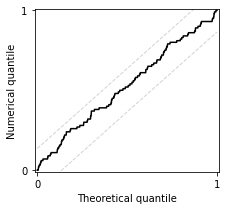

In [65]:
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
# file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated_kernel120ms_model_par_list.pkl'
file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_kernel125ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_inference(model_par_list, verbose=False)

# file_path = project_dir + 'Output/fig/amarasingham_nuisance_regression_kernel120ms_null_pval_distribution.pdf'
# jittertool.plot_p_value_distribution([p_vals_null], bin_width=0.05, file_path=None)
file_path = project_dir + 'Output/fig/linear_cox_kernel125ms_null_pval_qq_pot.pdf'
jittertool.plot_p_value_qq_plot(p_vals_null, file_path=file_path)

#### Jitter detection on Linear Cox dataset.

num_models 100
num_models 100
num_models 100
num_models 100
num_neg:100	um_pos:100	
num_neg:100	um_pos:100	
num_neg:100	um_pos:100	
save figure: D:/Brain_Network/Output/fig/linear_cox_beta30ms_jwindow100ms_roc.pdf


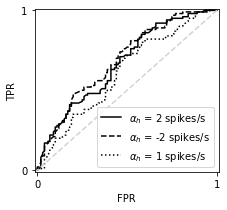

In [73]:
# Positive filters.
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_jitter/'

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow100ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null,_ = jittertool.extract_simultaneous_pval(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow100ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals1,_ = jittertool.extract_simultaneous_pval(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow100ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
_,p_vals2 = jittertool.extract_simultaneous_pval(model_par_list, verbose=False)

file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha1_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow100ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals3,_ = jittertool.extract_simultaneous_pval(model_par_list, verbose=False)

file_path = project_dir + 'Output/fig/linear_cox_beta30ms_jwindow100ms_roc.pdf'
model_labels = [r'$\alpha_h$ = 2 spikes/s', r'$\alpha_h$ = -2 spikes/s', r'$\alpha_h$ = 1 spikes/s']
jittertool.roc(neg_pos_score_pairs=[(p_vals_null, p_vals1), (p_vals_null, p_vals2), (p_vals_null, p_vals3)], 
               model_labels=model_labels, file_path=file_path)


num_models 100
Save figure to: D:/Brain_Network/Output/fig/linear_cox_jwindow60ms_null_pval_qq_pot.pdf


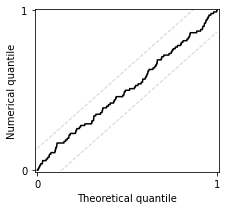

In [61]:
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_jitter/'
# file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow100ms_model_par_list.pkl'
# file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow140ms_model_par_list.pkl'
file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma_100ms_trials10_nonrepeated_jwindow60ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null,_ = jittertool.extract_simultaneous_pval(model_par_list, verbose=False)

# file_path = project_dir + 'Output/fig/amarasingham_nuisance_regression_kernel120ms_null_pval_distribution.pdf'
# jittertool.plot_p_value_distribution([p_vals_null], bin_width=0.05, file_path=None)
file_path = project_dir + 'Output/fig/linear_cox_jwindow60ms_null_pval_qq_pot.pdf'
jittertool.plot_p_value_qq_plot(p_vals_null, file_path=file_path)

###  Jitter regression model
Model fitting then save model list.

In [66]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/'
model_name = 'amarasingham_square_alpha0_beta40ms'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
model_par_list = []

model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 100, 'jitter_window_width': 0.07,
             'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1, 
#              'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12, 
#              'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

num_itrs = 300
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout) # range(num_itrs)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]

    model_par_raw, model_par_jitter = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
        spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=False)
    model_par_list.append((model_par_raw, model_par_jitter))
#     jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter,
#         generator_par, ylim=[-2, 8], file_path=None)

file_path = model_dir + f'{model_name}_kernel70ms_jitter_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 300/300 [40:51<00:00,  8.17s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0_beta40ms_kernel70ms_jitter_model_par_list.pkl


num_models:300
num_models:300
num_models:300
num_neg:300	um_pos:300	
num_neg:300	um_pos:300	
save figure: D:/Brain_Network/Output/fig/amarasingham_square_alpha_N0.5_N1_beta40ms_kernel50ms_jitter_regression_roc.pdf


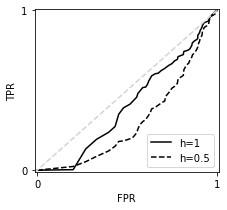

In [64]:
file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alpha0_beta40ms_kernel50ms_jitter_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter_inference(model_par_list, verbose=False)

file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alphaN1_beta40ms_kernel50ms_jitter_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals1 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter_inference(model_par_list, verbose=False)

file_path = project_dir + 'Output/jitter/bivariate_coupling_model/amarasingham_square_alphaN0.5_beta40ms_kernel50ms_jitter_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals2 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter_inference(model_par_list, verbose=False)

file_path = project_dir + 'Output/fig/amarasingham_square_alpha_N0.5_N1_beta40ms_kernel50ms_jitter_regression_roc.pdf'
jittertool.roc(neg_pos_score_pairs=[(p_vals_null, p_vals1), (p_vals_null, p_vals2)], file_path=None)

num_models:300


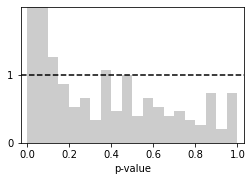

In [75]:
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/'
file_path = model_dir + 'amarasingham_square_alpha0_beta40ms_kernel50ms_jitter_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
p_vals_null = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter_inference(model_par_list, verbose=False)

file_path = project_dir + 'Output/fig/amarasingham_jitter_regression_kernel70ms_null_pval_distribution.pdf'
jittertool.plot_p_value_distribution([p_vals_null], bin_width=0.05, file_path=None)

# KS test.

num_trials 100
X.shape (11946, 10), basis_integral.shape (10, 1),beta.shape(10, 1)
 67%|████████████████████████████████████████▊                    | 67/100 [00:00<00:00, 763.38it/s]
gradient [-1.08909654e-06 -3.18326649e-04  5.61589708e-06  9.62203232e-06  1.38990323e-05  2.48362386e-05
  2.58889265e-05  2.69721594e-05  2.21695969e-05 -4.38160725e-07]
num itr 67 [[-26228.92352413]] 9.23750676912194e-06
beta [30.47043736  0.44848946 -4.34842936 -5.23901111 -1.69646445 -5.78833587 -3.8460435  -3.70706336 -6.47138047
  1.97251277]
filter integral [-0.22191467]


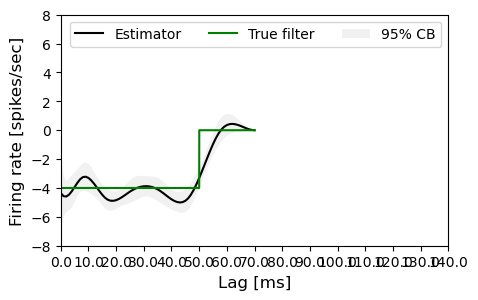

In [31]:
jittertool = jitter.JitterTool()

# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'dt': 0.0005, 'filter_type': 'none',
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.1, 'filter_length': 0.07, 'num_tail_drop': 2,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par, generator_par, ylim=[-8, 8])

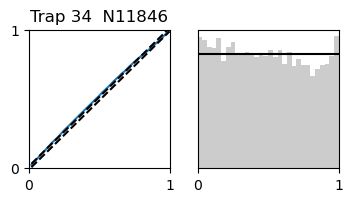

In [32]:
model_par_ks_test = jittertool.ks_test(
        spike_times_x, spike_times_y, trial_window, model_par_hat, dt=0.0001, test_size=0.05, verbose=True)

# Discrete-time regression

#### Continuous-time.

num_trials 200
X.shape (43283, 6), basis_integral.shape (6, 1),beta.shape(6, 1)
  7%|████▎                                                         | 7/100 [00:00<00:00, 155.96it/s]
gradient [-6.46683463e-06 -2.31907780e-04 -3.70140643e-06 -8.69675625e-06 -8.01570940e-06 -6.72099230e-06]
num itr 7 [[-120231.15161787]] 1.675530839934103e-06
beta [39.14338409  0.13970848  1.78664376  3.16626407  2.42511855  1.92407617]
filter integral [0.10398171]


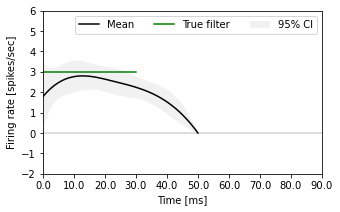

In [240]:
# model_par = {'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par = {'filter_type': 'bspline', 'num_knots': 3, 'knot_space_par': 0.1, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x, spike_times_y, [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par, generator_par, ylim=[-2,6])

##### Discrete-time

In [248]:
# model_par_discrete = {'dt': 0.0005, 'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete = {'dt': 0.001, 'filter_type': 'bspline', 'num_knots': 3, 'knot_space_par': 0.1, 
        'filter_length': 0.05, 'num_tail_drop': 1,
        'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.1,
        'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x, spike_times_y, trial_window, model_par_discrete, verbose=True)

discrete integral    [[ 1.00000000e+03 -9.34378832e-11  2.04117374e+02  4.96282411e+02  4.96001407e+02  4.94939278e+02]]
continuous integral  [[1.00000000e+03 0.00000000e+00 0.00000000e+00 ... 9.58556269e-04 9.44085617e-04 9.26586738e-04]]
num spikes x 39811 y 43283
X.shape (1000000, 6)
continuous integral  [[1.00000000e+03 0.00000000e+00 0.00000000e+00 ... 9.58556269e-04 9.44085617e-04 9.26586738e-04]]
discrete integral    [[ 1.00000000e+03 -9.34378832e-11  2.04117374e+02  4.96282411e+02  4.96001407e+02  4.94939278e+02]]
itr0	nll: -119797.0	beta: [39.23327975  0.11171458  1.14246496  2.48667953  1.70785244  2.01150665]
itr1	nll: -120217.1	beta: [38.94040124  0.13218871  1.53344984  3.26320441  2.17752215  2.38442026]
itr2	nll: -120240.7	beta: [38.89505275  0.13561287  1.60750275  3.42291907  2.26155279  2.45674276]
itr3	nll: -120241.5	beta: [38.8881387   0.13610521  1.61808444  3.44827654  2.27344036  2.46931185]
itr4	nll: -120241.5	beta: [38.88709625  0.13617375  1.61950114  3.452077

In [ ]:
[39.14338409  0.13970848  1.78664376  3.16626407  2.42511855  1.92407617]

[38.88691184  0.13618472  1.61971505  3.45273865  2.27526665  2.47182976]


# Bspline bases

#### Bspline bases.

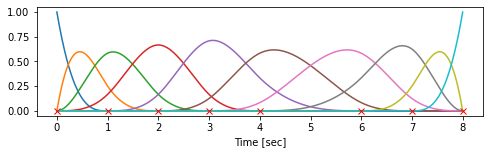

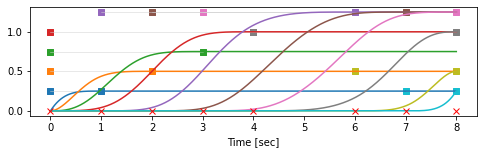

In [91]:
jittertool = jitter.JitterTool()
distinct_knots = [0,1,2,3,4,6,7,8]
# _ = jittertool.bspline_basis(1, distinct_knots, 0.01, verbose=True)
# _ = jittertool.bspline_basis(2, distinct_knots, 0.01, verbose=True)
# _ = jittertool.bspline_basis(3, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(4, distinct_knots, 0.01, verbose=True)

#### Derivatices.

In [ ]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(1, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(2, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(2, distinct_knots, 0.01, derivative_ord=1, verbose=True)

In [ ]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(2, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(3, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(3, distinct_knots, 0.01, derivative_ord=1, verbose=True)

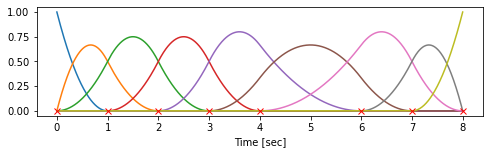

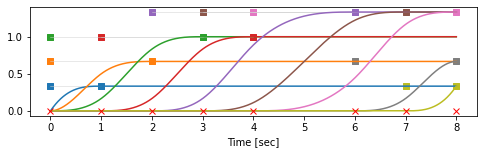

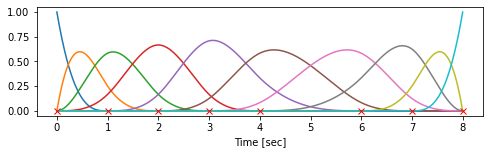

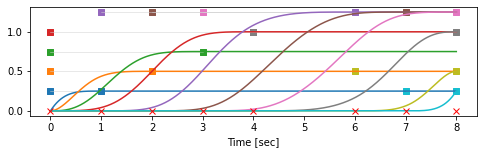

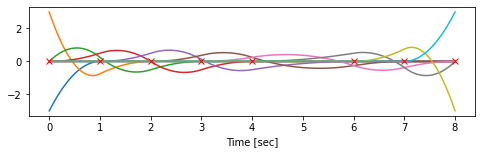

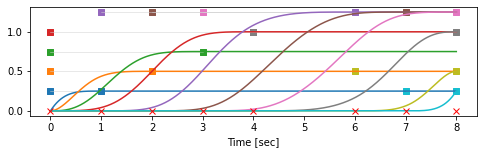

In [107]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(3, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(4, distinct_knots, 0.01, verbose=True)
_ = jittertool.bspline_basis(4, distinct_knots, 0.01, derivative_ord=1, verbose=True)

#### Integrals.

In [ ]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(1, distinct_knots, 0.01, verbose=True)

In [ ]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(2, distinct_knots, 0.01, verbose=True)

In [ ]:
distinct_knots = [0,1,2,3,4,6,7,8]
_ = jittertool.bspline_basis(3, distinct_knots, 0.01, verbose=True)

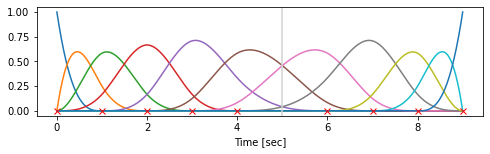

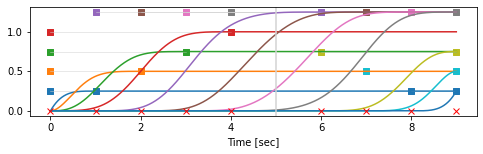

In [128]:
distinct_knots = [0,1,2,3,4,6,7,8,9]
_ = jittertool.bspline_basis(4, distinct_knots, [5], verbose=True)

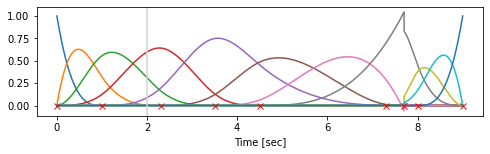

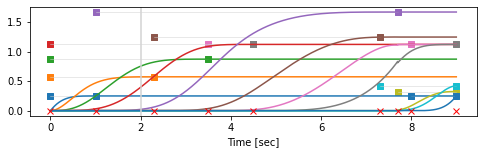

In [158]:
distinct_knots = [0,1,2.3,3.5,4.5,7.7,7.3, 8,9]
_ = jittertool.bspline_basis(4, distinct_knots, [2], num_tail_drop=0, verbose=True)

#### Create knots.

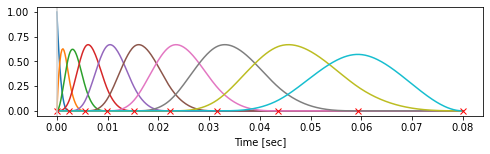

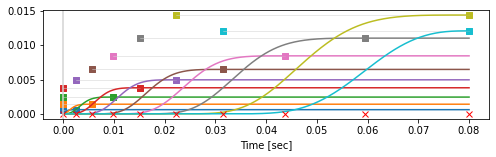

knots [0.         0.0024424  0.00563046 0.00979184 0.01522369 0.02231388 0.0315687  0.04364902 0.05941746
 0.08      ]
AUC [0.0006106  0.00140762 0.00244796 0.00380592 0.00496787 0.00648456 0.00846429 0.01104844 0.01442153
 0.01210783]


In [617]:
jittertool = jitter.JitterTool()
knots = jittertool.allocate_basis_knots(10, 0.08, verbose=True)